# Download Dataset

In [ ]:
! wget http://madm.dfki.de/files/sentinel/EuroSAT.zip
! unzip EuroSAT.zip
! git clone https://github.com/gasvn/Res2Net.git
! pip install ipython-autotime

Streaming output truncated to the last 5000 lines.
  inflating: 2750/SeaLake/SeaLake_1462.jpg  
  inflating: 2750/SeaLake/SeaLake_512.jpg  
  inflating: 2750/SeaLake/SeaLake_960.jpg  
  inflating: 2750/SeaLake/SeaLake_2577.jpg  
  inflating: 2750/SeaLake/SeaLake_2905.jpg  
  inflating: 2750/SeaLake/SeaLake_173.jpg  
  inflating: 2750/SeaLake/SeaLake_1003.jpg  
  inflating: 2750/SeaLake/SeaLake_2116.jpg  
  inflating: 2750/SeaLake/SeaLake_1546.jpg  
  inflating: 2750/SeaLake/SeaLake_1934.jpg  
  inflating: 2750/SeaLake/SeaLake_844.jpg  
  inflating: 2750/SeaLake/SeaLake_436.jpg  
  inflating: 2750/SeaLake/SeaLake_391.jpg  
  inflating: 2750/SeaLake/SeaLake_2821.jpg  
  inflating: 2750/SeaLake/SeaLake_2453.jpg  
  inflating: 2750/SeaLake/SeaLake_1127.jpg  
  inflating: 2750/SeaLake/SeaLake_1680.jpg  
  inflating: 2750/SeaLake/SeaLake_2032.jpg  
  inflating: 2750/SeaLake/SeaLake_2795.jpg  
  inflating: 2750/SeaLake/SeaLake_2744.jpg  
  inflating: 2750/SeaLake/SeaLake_1651.jpg  
  inflatin

# Import Dependencies

In [ ]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import ConcatDataset
import torchvision.transforms as transforms
from torchvision import models
from torchvision import utils
from torchsummary import summary
import torch.nn.functional as F

import numpy as np
import os
import cv2
import random
import numpy as np
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sb
import matplotlib.pyplot as plt

from IPython.display import clear_output
from google.colab import files

from Res2Net import res2net

%load_ext autotime

time: 121 µs


# Load Dataset

In [ ]:
BASE_PATH = "./2750"
CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda") if CUDA else torch.device("cpu")
BATCH_SIZE = 10
EPOCHS = 60
LABELS = sorted(os.listdir(BASE_PATH))
CLASSES = len(LABELS)
LABEL_DICT = { LABELS[index] : index for index in range(CLASSES) }
LEARNING_RATE = 0.0001
TEST_RATIO = 0.2

time: 113 ms


In [ ]:
def read_data(labels = LABELS):
  X = []
  Y = []
  
  for label in labels :
    each_class_path = os.path.join(BASE_PATH, label)

    for img in os.listdir(each_class_path) :
      image_path = os.path.join(each_class_path, img)
      image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

      X.append(image)
      Y.append(label)      
    
  X = np.array(X)
  Y = np.array(Y)
  return X, Y

time: 7.13 ms


In [ ]:
X, Y = read_data()
X.shape, Y.shape

((27000, 64, 64, 3), (27000,))

time: 4.1 s


In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, test_size=TEST_RATIO, random_state=2, shuffle=True, stratify=Y)
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((21600, 64, 64, 3), (5400, 64, 64, 3), (21600,), (5400,))

time: 228 ms


# Dataset Loader

In [ ]:
class ProcessTrainImage(object):
  def __call__(self, sample):
    image_transformations = transforms.Compose([
                                          transforms.ToPILImage(),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomVerticalFlip(),
                                          transforms.RandomRotation(degrees=90),
                                          transforms.ToTensor(),
                                          transforms.Normalize(
                                              mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225]
                                              )
                                          ])

    image, label = sample['image'], sample['label']
    transformed_image = image_transformations(image)
    transformed_label = to_categorical(label, num_classes=CLASSES)

    transformed_sample = {
        'image': transformed_image,
        'label': transformed_label
    }
    return transformed_sample


time: 15.5 ms


In [ ]:
class ProcessTestImage(object):
  def __call__(self, sample):
    image_transformations = transforms.Compose([
                                          transforms.ToPILImage(),
                                          transforms.ToTensor(),
                                          transforms.Normalize(
                                              mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225]
                                              )
                                          ])

    image, label = sample['image'], sample['label']
    transformed_image = image_transformations(image)
    transformed_label = to_categorical(label, num_classes=CLASSES)

    transformed_sample = {
        'image': transformed_image,
        'label': transformed_label
    }
    return transformed_sample


time: 13 ms


In [ ]:
class EuroSatDataset(Dataset):
  def __init__(self, images, labels, transform=None):
    self.images = images
    self.labels = labels
    self.transform = transform
  
  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    image = self.images[index]
    label = LABEL_DICT[self.labels[index]]

    data = {'image':image, 'label':label}

    if self.transform:
      data = self.transform(data)
    return data

time: 14.4 ms


In [ ]:
def create_train_test_loaders(batch_size):  
  train_set = EuroSatDataset(Xtrain, ytrain, transform=ProcessTrainImage())
  test_set = EuroSatDataset(Xtest, ytest, transform=ProcessTestImage())

  train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

  return train_loader, test_loader

time: 6.68 ms


# Define Pretrained Models

In [ ]:
def freeze_params(parameters):
  for param in parameters:
    param.requires_grad = False

time: 1.97 ms


In [ ]:
def unfreeze_params(parameters):
  for param in parameters:
    param.requires_grad = True

time: 1.94 ms


In [ ]:
def transfer_model(pretrained_model, layers_to_train):
  model = pretrained_model(pretrained=True)

  model.fc = nn.Linear(model.fc.in_features, CLASSES)

  freeze_params(model.parameters())

  if layers_to_train=="last_layer":
    params = model.fc.parameters()
  
  if layers_to_train=="all":
    params = model.parameters()
  
  unfreeze_params(params)

  return model.to(DEVICE)

time: 11.3 ms


In [ ]:
def pretrained_res2net50_14w_8s(layers_to_train="all"):
  model = transfer_model(res2net.res2net50_14w_8s, layers_to_train)
  return model

time: 2.9 ms


In [ ]:
def pretrained_res2net50_26w_4s(layers_to_train="all"):
  model = transfer_model(res2net.res2net50_26w_4s, layers_to_train)
  return model

time: 2.06 ms


In [ ]:
def pretrained_res2net50_26w_6s(layers_to_train="all"):
  model = transfer_model(res2net.res2net50_26w_6s, layers_to_train)
  return model

time: 2.68 ms


In [ ]:
def pretrained_res2net50_26w_8s(layers_to_train="all"):
  model = transfer_model(res2net.res2net50_26w_8s, layers_to_train)
  return model

time: 3.11 ms


In [ ]:
def pretrained_res2net50_48w_2s(layers_to_train="all"):
  model = transfer_model(res2net.res2net50_48w_2s, layers_to_train)
  return model

time: 1.63 ms


In [ ]:
def pretrained_resnet50(layers_to_train="all"):
  model = transfer_model(models.resnet50, layers_to_train)
  return model

time: 2.95 ms


In [ ]:
all_models = {
    'resnet50' : pretrained_resnet50,    
    'res2net50_14w_8s' : pretrained_res2net50_14w_8s,
    'res2net50_26w_4s' : pretrained_res2net50_26w_4s,
    'res2net50_26w_6s' : pretrained_res2net50_26w_6s,
    'res2net50_26w_8s' : pretrained_res2net50_26w_8s,
    'res2net50_48w_2s' : pretrained_res2net50_48w_2s
}

time: 2.66 ms


# Train Model

In [ ]:
def test_model(model, test_loader, criterion, device):
  test_accuracy = 0
  test_loss = 0
  true_labels = []
  pred_labels = []

  model.eval()
  for batch in test_loader:
    image_batch = batch['image'].to(device)
    label_batch = batch['label'].to(device)
    _, label_batch = torch.max(label_batch, 1)

    y_pred = model(image_batch)
    batch_loss = criterion(y_pred, label_batch)

    _, output_labels = torch.max(y_pred, 1)
    correct = label_batch.eq(output_labels).cpu().numpy()

    test_accuracy += sum(correct)
    test_loss += batch_loss.item() * image_batch.size(0)

    true_labels += list(label_batch.cpu().numpy())
    pred_labels += list(output_labels.cpu().numpy())

  average_testing_loss = test_loss / len(test_loader.sampler)
  average_testing_accuracy = test_accuracy / len(test_loader.sampler)

  return average_testing_loss, average_testing_accuracy, true_labels, pred_labels

time: 23.8 ms


In [ ]:
def train_model(model, train_loader, test_loader, optimizer, criterion, epochs, device, save_path):
  min_train_loss = np.inf

  train_losses = []
  test_losses = []
  train_accuracies = []
  test_accuracies = []

  for epoch in range(epochs):
    train_loss = 0
    test_loss = 0
    train_accuracy = 0
    test_accuracy = 0

    model.train()
    for batch in train_loader:
      image_batch = batch['image'].to(device)
      label_batch = batch['label'].to(device)
      _, label_batch = torch.max(label_batch, 1)

      optimizer.zero_grad()
      y_pred = model(image_batch)
      batch_loss = criterion(y_pred, label_batch)
      batch_loss.backward()
      optimizer.step()

      _, output_labels = torch.max(y_pred, 1)
      correct = label_batch.eq(output_labels).cpu().numpy()
      train_accuracy += sum(correct)
      train_loss += batch_loss.item() * image_batch.size(0)

    average_training_loss = train_loss / len(train_loader.sampler)
    average_training_accuracy = train_accuracy / len(train_loader.sampler)

    average_testing_loss, average_testing_accuracy, _, _ = test_model(
        model, test_loader, 
        criterion, device
        )    
    
    train_losses.append(average_training_loss)
    test_losses.append(average_testing_loss)
    train_accuracies.append(average_training_accuracy)
    test_accuracies.append(average_testing_accuracy)

    print('Epoch: {} \t Train Loss: {:.6f} \t Test Loss: {:.6f} \t Train Accuracy: {:.4f} \t Test Accuracy: {:.4f}'.format(epoch, average_training_loss, average_testing_loss, average_training_accuracy, average_testing_accuracy))
    
    if min_train_loss > average_training_loss :
      print('Model improved - Saving Model')
      min_train_loss = average_training_loss
      torch.save(model.state_dict(), save_path)      
  
  return train_losses, test_losses, train_accuracies, test_accuracies


time: 45.1 ms


In [ ]:
def random_seed():
  torch.manual_seed(0)
  np.random.seed(0)
  random.seed(0)

  if CUDA:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

time: 6.45 ms


In [ ]:
LAYERS_TO_TRAIN = 'last_layer'
model_name  = 'res2net50_48w_2s'

random_seed()
train_loader, test_loader = create_train_test_loaders(BATCH_SIZE)

model = all_models[model_name](LAYERS_TO_TRAIN)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

save_path = model_name + '_weights_' + LAYERS_TO_TRAIN + '_' + str(TEST_RATIO) + '.pt'

train_losses, test_losses, train_accuracies, test_accuracies = train_model(
      model=model, 
      train_loader=train_loader, 
      test_loader=test_loader, 
      optimizer=optimizer, 
      criterion=criterion, 
      epochs=EPOCHS, 
      device=DEVICE,
      save_path=save_path
      )

clear_output(wait=True)

time: 1h 15min 1s


# Validation and Visualization

In [ ]:
def save_results(average_testing_accuracy, c_report, filename):
  if not os.path.exists("Results"):
    os.makedirs("Results")

  filename = os.path.join("Results", filename)

  with open(filename, 'w') as x_file:
    x_file.write('Test accuracy - ' + str(average_testing_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('Classification report : \n')
    x_file.write(str(c_report))
    x_file.write('\n')


time: 7.35 ms


In [ ]:
def plot_confusion_matrix(y_true, y_pred, filename):
  sb.set(font_scale=1.5)

  if not os.path.exists("Figures"):
    os.makedirs("Figures")

  filename = os.path.join("Figures", filename)
  
  cm = confusion_matrix(y_true, y_pred)

  plt.figure(figsize=(12, 10))
  sb.heatmap(cm, annot=True, fmt="d", linewidths=5, xticklabels=LABELS, yticklabels=LABELS)

  plt.savefig(filename)
  plt.show()

time: 10.3 ms


Confusion matrix 


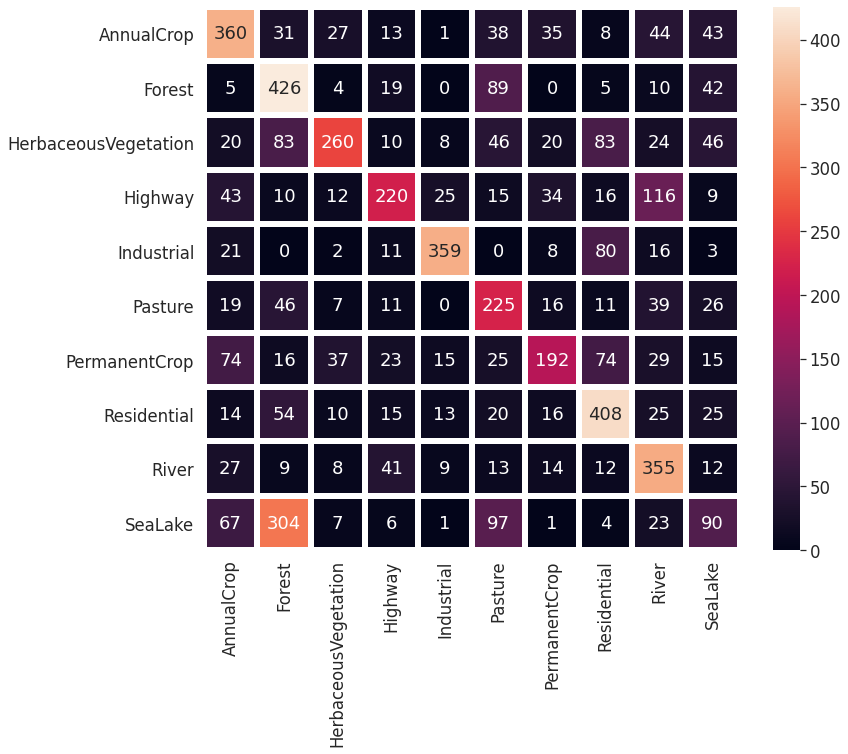


time: 14.6 s


In [ ]:
_, test_loader = create_train_test_loaders(BATCH_SIZE)
model = all_models[model_name](LAYERS_TO_TRAIN)

save_path = model_name + '_weights_' + LAYERS_TO_TRAIN + '_' + str(TEST_RATIO) + '.pt'
model.load_state_dict(torch.load(save_path))

average_testing_loss, average_testing_accuracy, y_true, y_pred = test_model(
    model=model, 
    test_loader=test_loader, 
    criterion=criterion, 
    device=DEVICE
    )

c_report = classification_report(y_true, y_pred, digits=4, target_names=LABELS)
filename = model_name + '_weights_' + LAYERS_TO_TRAIN + '_' + str(TEST_RATIO) + '.txt'
save_results(average_testing_accuracy, c_report, filename)

print("Confusion matrix ")
filename = model_name + '_weights_' + LAYERS_TO_TRAIN + '_' + str(TEST_RATIO) + '.png'
plot_confusion_matrix(y_true, y_pred, filename)
print("")